### Importation de Bibliothèques nécessaires 

In [12]:
from atproto import Client
import psycopg2
import traceback
import re
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer


In [1]:
# Connexion à Bluesky
client = Client()
client.login('*****', '*****')

ProfileViewDetailed(did='did:plc:gnawnf2ojq6hcfuykbx7wzzn', handle='hananehouria.bsky.social', associated=ProfileAssociated(chat=None, feedgens=0, labeler=False, lists=0, starter_packs=0, py_type='app.bsky.actor.defs#profileAssociated'), avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:gnawnf2ojq6hcfuykbx7wzzn/bafkreif3aeldon4haimsgz4wqvumj67qustapcuuy7lpnokfsh5np7leym@jpeg', banner=None, created_at='2025-03-04T09:30:25.846Z', description=None, display_name='', followers_count=1, follows_count=1, indexed_at='2025-03-04T09:30:25.846Z', joined_via_starter_pack=None, labels=[], pinned_post=None, posts_count=3, viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, known_followers=None, muted=False, muted_by_list=None, py_type='app.bsky.actor.defs#viewerState'), py_type='app.bsky.actor.defs#profileViewDetailed')

In [8]:
post = client.send_post('Hello world! I posted this via the Python SDK.')

In [9]:
post.uri  # at://did:plc:abc123..../app.bsky.feed.post/xyz...
post.cid  # abc...

'bafyreihnu23hacwq2b4577ombheasakrjnov2wk3ua3da4sixqnyemtkdi'

In [10]:
# Obtenir le DID
profil = client.resolve_handle('hananehouria.bsky.social')

print("DID de l'utilisateur:", profil.did)

DID de l'utilisateur: did:plc:gnawnf2ojq6hcfuykbx7wzzn


In [58]:
# Connexion à Bluesky
client = Client()
client.login('hananehouria.bsky.social', 'qDsV9tkgTkh7iqz')

# Récupérer les derniers posts de l'utilisateur
feed = client.app.bsky.feed.get_author_feed({
    'actor': 'hananehouria.bsky.social',
    'limit': 10  # tu peux modifier le nombre de posts récupérés
})

# Afficher les textes des posts
for item in feed.feed:
    post = item.post
    text = post.record.text
    created_at = post.record.created_at
    print(f"Date : {created_at} \nTexte : {text}\n---")


Date : 2025-04-14T19:46:21.949595+00:00 
Texte : Hello world! I posted this via the Python SDK.
---
Date : 2025-03-25T21:38:10.343799+00:00 
Texte : Hello world! I posted this via the Python SDK.
---
Date : 2025-03-25T21:21:58.706Z 
Texte : hello
---


## Collecte de données

In [6]:
# ==============================
# --- Paramètres de connexion ---
# ==============================

BLUESKY_HANDLE = 'hananehouria.bsky.social'
BLUESKY_PASSWORD = 'qDsV9tkgTkh7iqz'

DB_HOST = 'localhost'
DB_NAME = 'postgres'
DB_USER = 'postgres'
DB_PASSWORD = 'root'

# ==============================
# --- Connexion à Bluesky ---
# ==============================

client = Client()
client.login(BLUESKY_HANDLE, BLUESKY_PASSWORD)

# ==============================
# --- Fonctions utilitaires ---
# ==============================

def extract_hashtags_mentions(text):
    """
    Extrait les hashtags (#tag) et mentions (@user) depuis un texte.
    """
    hashtags = re.findall(r'#\w+', text)
    mentions = re.findall(r'@\w+', text)
    return hashtags, mentions

def detect_content_type(post):
    """
    Détecte le type de contenu : texte, image, vidéo ou lien externe.
    """
    embed = getattr(post, "embed", None)
    if embed:
        if hasattr(embed, "images") and embed.images:
            return "image"
        elif hasattr(embed, "external"):
            external_uri = getattr(embed.external, "uri", "")
            if any(x in external_uri for x in [".mp4", "youtube.com", "vimeo.com"]):
                return "video"
            return "external"
        else:
            return "embed"
    return "text"

def get_and_insert_posts(actor_handle, client, cursor):
    """
    Récupère les derniers posts de l'utilisateur spécifié et les insère dans la base PostgreSQL.
    """
    try:
        feed = client.app.bsky.feed.get_author_feed({
            'actor': actor_handle,
            'limit': 100
        })

        for item in feed.feed:
            try:
                post = item.post
                uri = post.uri
                text = post.record.text
                author = post.author.handle
                created_at = post.indexed_at
                link = f"https://bsky.app/profile/{author}/post/{uri.split('/')[-1]}"

                like_count = post.like_count or 0
                repost_count = post.repost_count or 0
                reply_count = post.reply_count or 0

                hashtags, mentions = extract_hashtags_mentions(text)
                content_type = detect_content_type(post)

                cursor.execute("""
                    INSERT INTO posts_bsky (uri, auteur, texte, date_creation, lien, 
                        like_count, repost_count, reply_count, hashtags, mentions, content_type)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                    ON CONFLICT (uri) DO NOTHING
                """, (
                    uri, author, text, created_at, link,
                    like_count, repost_count, reply_count,
                    hashtags, mentions, content_type
                ))

            except Exception as e:
                print(f"❌ Erreur post {actor_handle} :", e)

    except Exception as e:
        print(f"❌ Erreur feed {actor_handle} :", e)

# ==============================
# --- Récupération récursive des followings ---
# ==============================

def get_followings_recursive(base_handle, depth=2):
    print("🔍 Récupération récursive des followings...")
    seen = set()
    to_process = [base_handle]

    for _ in range(depth):
        next_batch = []
        for handle in to_process:
            try:
                followings = client.app.bsky.graph.get_follows({"actor": handle, "limit": 100}).follows
                new_handles = [f.handle for f in followings if f.handle not in seen]
                seen.update(new_handles)
                next_batch.extend(new_handles)
            except Exception as e:
                print(f"❌ Erreur récupération followings pour {handle} :", e)
        to_process = next_batch

    return list(seen)

# ==============================
# --- Exécution principale ---
# ==============================

try:
    conn = psycopg2.connect(
        host=DB_HOST,
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD
    )
    cursor = conn.cursor()

    all_users = [BLUESKY_HANDLE] + get_followings_recursive(BLUESKY_HANDLE, depth=2)

    for user in all_users:
        get_and_insert_posts(user, client, cursor)

    conn.commit()
    print("✅ Tous les posts des comptes suivis (et de leurs followings) ont été insérés avec succès.")

except Exception as global_error:
    print(" Erreur globale:", global_error)
    traceback.print_exc()

finally:
    try:
        if cursor:
            cursor.close()
        if conn:
            conn.close()
    except:
        pass


🔍 Récupération récursive des followings...
✅ Tous les posts des comptes suivis (et de leurs followings) ont été insérés avec succès.


## Analyse des tweets

In [13]:
df = pd.read_csv('posts_bsky.csv')
display(df.head())

,uri,auteur,texte,date_creation,lien,like_count,repost_count,reply_count,hashtags,mentions,content_type
0,at://did:plc:222onfharw6dp4gskys2bfhl/app.bsky...,turini2.bsky.social,John Green as “Silly Ray Cyrus” as part of the...,2025-02-14 17:27:04.049,https://bsky.app/profile/turini2.bsky.social/p...,88,21,2,{#p4a2025},{@projectforawesome},embed
1,at://did:plc:22i2lqqdlitnd55xo45xucsk/app.bsky...,oakcopoversight.bsky.social,Great conversation on copaganda this Saturday ...,2025-04-22 17:57:27.185,https://bsky.app/profile/oakcopoversight.bsky....,17,6,0,{},{},image
2,at://did:plc:23tjefyt2vhs2hqxeiooy4t4/app.bsky...,aflcio.org,Now is the time to be even louder for Kilmar A...,2025-04-21 21:08:59.879,https://bsky.app/profile/aflcio.org/post/3lne3...,503,174,2,{},{},external
3,at://did:plc:23zwh5cbga32gbcisjlk3b3j/app.bsky...,wbez.org,Democratic Illinois Gov. JB Pritzker lambasted...,2025-04-17 20:16:46.78,https://bsky.app/profile/wbez.org/post/3lmzwee...,276,66,5,{},{},external
4,at://did:plc:247gdcjchxzljmr6y2c65qvn/app.bsky...,barryp.bsky.social,I am a Saturn evangelist. defector.com/i-implo...,2025-05-01 19:02:50.788,https://bsky.app/profile/barryp.bsky.social/po...,105,11,11,{},{},external


In [14]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20583 entries, 0 to 20582
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   uri            20583 non-null  object
 1   auteur         20583 non-null  object
 2   texte          20255 non-null  object
 3   date_creation  20583 non-null  object
 4   lien           20583 non-null  object
 5   like_count     20583 non-null  int64 
 6   repost_count   20583 non-null  int64 
 7   reply_count    20583 non-null  int64 
 8   hashtags       20583 non-null  object
 9   mentions       20583 non-null  object
 10  content_type   20583 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.7+ MB


None

## Statistiques globales

In [15]:
print("Nombre total de posts:", len(df))
print("Période couverte :", df['date_creation'].min(), "→", df['date_creation'].max())
print("Posts par auteur :\n", df['auteur'].value_counts().head(10))


Nombre total de posts: 20583
Période couverte : 2023-04-12 11:39:32.535 → 2025-05-04 17:22:21.787
Posts par auteur :
 auteur
hankgreen.bsky.social             116
bsky.app                          106
nbcnews.com                       105
markhamillofficial.bsky.social    103
kyledcheney.bsky.social           103
jamesgunn.bsky.social             102
thedavidpakmanshow.bsky.social    102
discussingfilm.net                101
kumail.bsky.social                101
sahilkapur.bsky.social            101
Name: count, dtype: int64


## RÉSUMÉ DES PUBLICATIONS 

In [16]:
# --- Conversion en datetime et suppression des dates invalides ---
df['date_creation'] = pd.to_datetime(df['date_creation'], errors='coerce')
df = df.dropna(subset=['date_creation'])

# --- Calcul des indicateurs clés ---
total_posts = len(df)
min_date = df['date_creation'].min().date()
max_date = df['date_creation'].max().date()

# Calcul du Top 10 des auteurs
top_counts = df['auteur'].value_counts().head(10)
# Extraction de la liste des (auteur, nombre)
top_list = list(zip(top_counts.index.tolist(), top_counts.values.tolist()))

# --- Formatage managé pour l’affichage ASCII ---

# 1) Une ligne de titre encadrée
header = " RÉSUMÉ DES PUBLICATIONS "
encadrement = "=" * len(header)
print(encadrement)
print(header)
print(encadrement, "\n")

# 2) Bloc « Nombre total » et « Période » au format aligné
print(f"{'Nombre total de posts':<25}: {total_posts:>7,}")
print(f"{'Période couverte':<25}: {min_date}  →  {max_date}\n")

# 3) Tableau « Top 10 des auteurs » en ASCII
#    On détermine la largeur des colonnes en fonction du plus long nom d’auteur
max_len_auteur = max(len(a) for a, _ in top_list)
col_auteur = max(max_len_auteur, len("Auteur")) + 2
col_nombre = max(len(str(max(count for _, count in top_list))), len("Nombre")) + 2

# En-tête du tableau
titre_tab = "Top 10 des auteurs"
print(titre_tab)
print("-" * (6 + col_auteur + col_nombre))  # 6 = largeur pour la colonne "Rang" + deux séparateurs

# Ligne d’en-tête des colonnes, avec rang, auteur et nombre
print(
    f"| {'Rang':^4} | "
    f"{'Auteur':^{col_auteur}} | "
    f"{'Nombre':^{col_nombre}} |"
)
print("-" * (6 + col_auteur + col_nombre))

# Lignes de données pour chaque auteur
for i, (auteur, count) in enumerate(top_list, start=1):
    print(
        f"| {i:^4d} | "
        f"{auteur:<{col_auteur}} | "
        f"{count:>{col_nombre}d} |"
    )

print("-" * (6 + col_auteur + col_nombre))


 RÉSUMÉ DES PUBLICATIONS 

Nombre total de posts    :  20,565
Période couverte         : 2023-04-12  →  2025-05-04

Top 10 des auteurs
----------------------------------------------
| Rang |              Auteur              |  Nombre  |
----------------------------------------------
|  1   | hankgreen.bsky.social            |      116 |
|  2   | bsky.app                         |      106 |
|  3   | nbcnews.com                      |      105 |
|  4   | kyledcheney.bsky.social          |      103 |
|  5   | markhamillofficial.bsky.social   |      103 |
|  6   | thedavidpakmanshow.bsky.social   |      102 |
|  7   | sahilkapur.bsky.social           |      101 |
|  8   | discussingfilm.net               |      101 |
|  9   | kumail.bsky.social               |      101 |
|  10  | jamesgunn.bsky.social            |      101 |
----------------------------------------------


## Évolution temporelle des posts

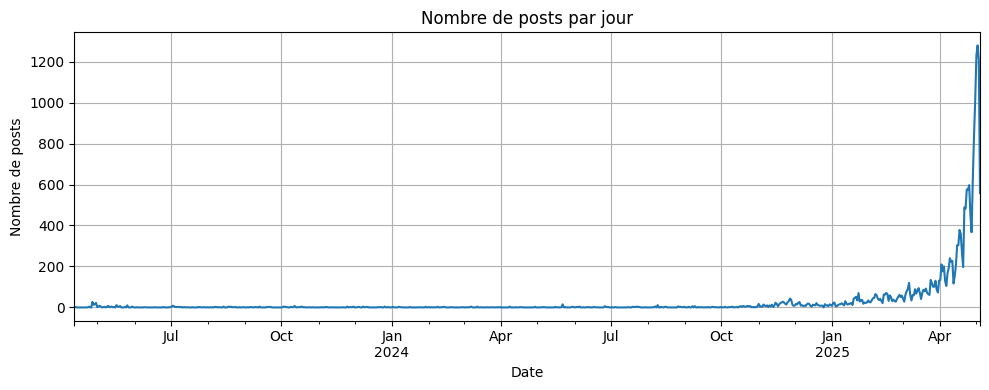

In [17]:
# Conversion robuste des dates
df['date_creation'] = pd.to_datetime(df['date_creation'], format='mixed', errors='coerce')

# Supprime les dates non valides
df = df.dropna(subset=['date_creation'])

# Résumé par jour
df.set_index('date_creation').resample('D').size().plot(
    title="Nombre de posts par jour", 
    figsize=(10, 4), 
    grid=True
)

plt.xlabel("Date")
plt.ylabel("Nombre de posts")
plt.tight_layout()
plt.show()

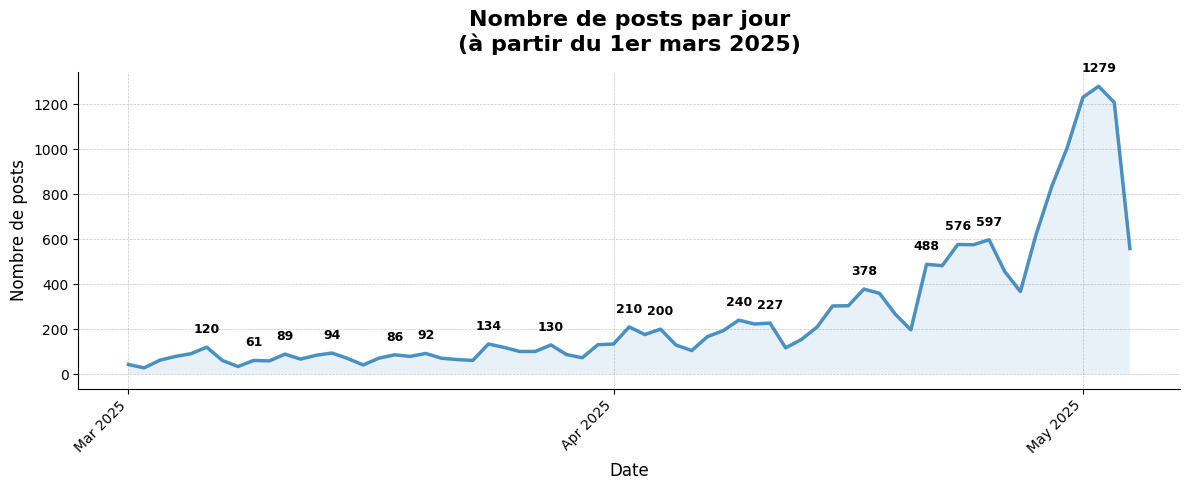

In [19]:
import numpy as np
# Conversion robuste des dates
df['date_creation'] = pd.to_datetime(df['date_creation'], format='mixed', errors='coerce')

# On supprime les enregistrements sans date valide
df = df.dropna(subset=['date_creation'])

# On ne garde que les posts à partir du 01/03/2025
start_date = "2025-03-01"
df_filtre = df[df['date_creation'] >= start_date]

# On crée la série journalière par comptage
serie_journaliere = df_filtre.set_index('date_creation').resample('D').size()

# Extraction des index (dates) et des valeurs (nombre de posts)
dates = serie_journaliere.index
values = serie_journaliere.values

# Détection des pics locaux :
# un point i est un pic si value[i] > value[i-1] et value[i] > value[i+1].
# On ignore les deux extrémités pour cette simplicité.
peaks_mask = (values[1:-1] > values[:-2]) & (values[1:-1] > values[2:])
peak_indices = np.where(peaks_mask)[0] + 1  # +1 pour compenser le décalage de l’intervalle [1:-1]

# Création de la figure et de l’axe
fig, ax = plt.subplots(figsize=(12, 5), dpi=100)

# Tracé de la courbe
ax.plot(
    dates,
    values,
    linewidth=2.5,    # Ligne plus épaisse
    alpha=0.8         # Légère transparence
)

# Remplissage léger sous la courbe (même couleur par défaut)
ax.fill_between(
    dates,
    values,
    alpha=0.1
)

# Annotation des pics : on place la valeur au-dessus de chaque pic détecté
for idx in peak_indices:
    x = dates[idx]
    y = values[idx]
    ax.annotate(
        str(int(y)),               # Texte à dessiner : valeur entière
        xy=(x, y),                 # Coordonnées du pic
        xytext=(0, 8),             # Décalage du texte en points (x=0, y=+8)
        textcoords='offset points',
        ha='center',               # Centre horizontalement le texte au-dessus du pic
        va='bottom',               # Le texte est au-dessus (bottom) du point
        fontsize=9,
        weight='bold',
        color='black'
    )

# Titre et labels
ax.set_title(
    "Nombre de posts par jour\n(à partir du 1er mars 2025)",
    fontsize=16,
    weight='bold',
    pad=15
)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nombre de posts", fontsize=12)

# Grille légère derrière la courbe
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)  # On place la grille derrière l’intrigue

# Suppression des bordures supérieures et droites
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Mise en forme des dates sur l’axe X :
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Rotation et taille des labels pour plus de lisibilité
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

# Ajustement de la marge pour que rien ne soit coupé
plt.tight_layout()

plt.show()


## Nuage de mots des publication

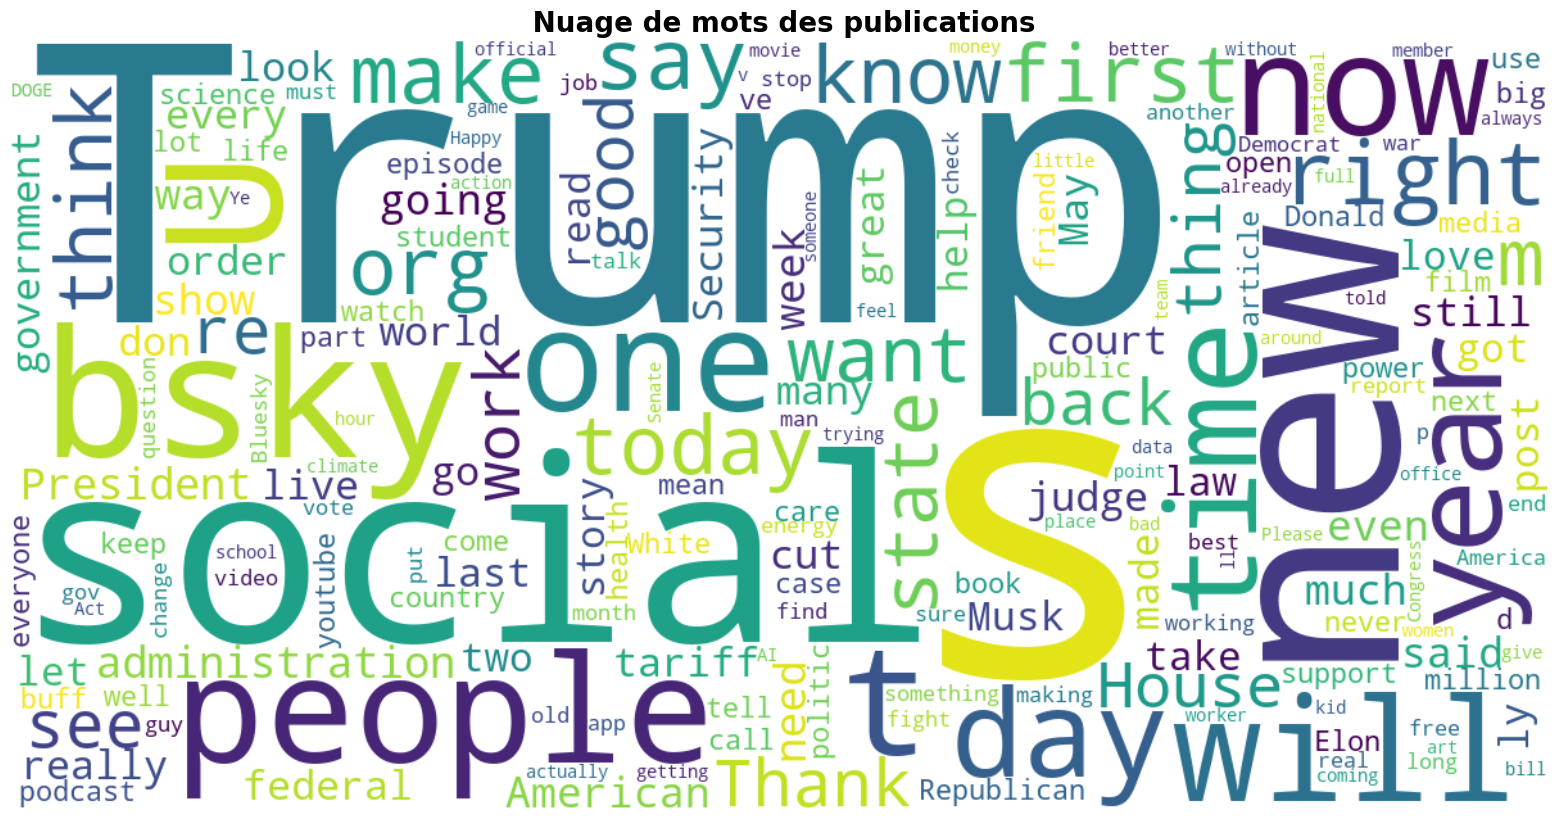

In [21]:

# Nettoyage du texte
text = " ".join(df['texte'].dropna().astype(str))

#  Mots à ignorer
stopwords = set(STOPWORDS)
stopwords.update([
    "https", "http", "www", "com", "rt", "amp",  # mots inutiles
    "le", "la", "les", "un", "une", "ce", "cela", "cette", "etc",  # mots français fréquents
])

# Personnalisation du WordCloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    colormap='viridis',  # Choix du style de couleurs
    contour_color='steelblue',
    contour_width=1,
    collocations=False,  # Supprime les doublons de paires de mots fréquents
    prefer_horizontal=0.9,
).generate(text)

#  Affichage
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(" Nuage de mots des publications", fontsize=20, fontweight='bold')
plt.tight_layout(pad=0)
plt.show()


In [22]:
top = df.sort_values(by='like_count', ascending=False).head(20)
print(top[['auteur', 'like_count', 'texte']])


                            auteur  like_count  \
19981                     bsky.app      216694   
234      petebuttigieg.bsky.social      173590   
13298              aoc.bsky.social      170353   
13251              aoc.bsky.social      169262   
13273              aoc.bsky.social      168744   
19933                     bsky.app      160915   
19988                     bsky.app      156426   
8113   ellenlweintraub.bsky.social      151560   
13257              aoc.bsky.social      148549   
13264              aoc.bsky.social      144573   
7020                corybooker.com      138277   
13288              aoc.bsky.social      134432   
13292              aoc.bsky.social      131987   
13295              aoc.bsky.social      131099   
19481   fredguttenberg.bsky.social      129919   
246      petebuttigieg.bsky.social      126912   
8181          vanhollen.senate.gov      126136   
12827   richardbranson.bsky.social      123289   
19934                     bsky.app      119228   


## Top 10 des posts par nombre de likes

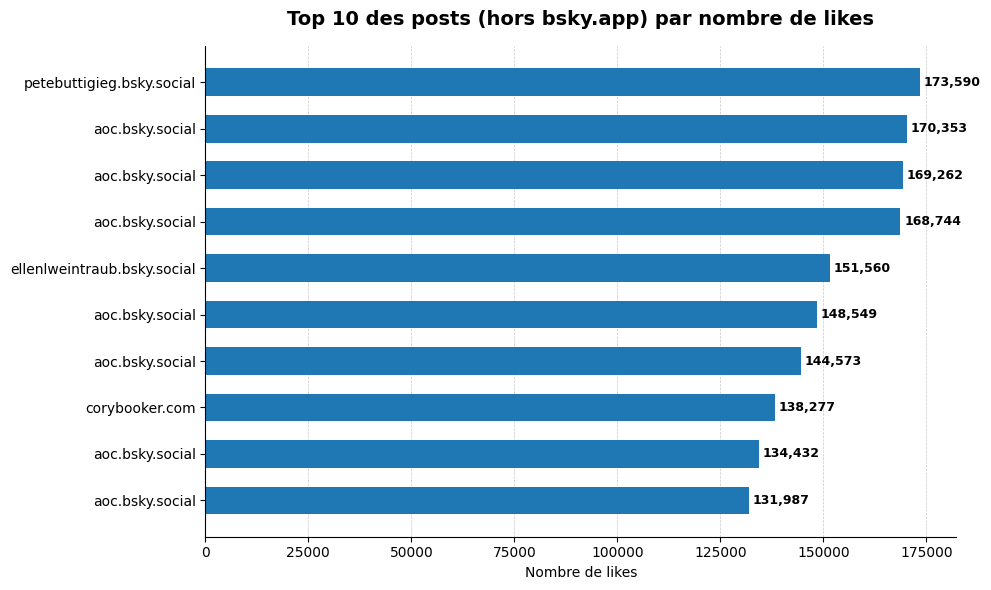

In [23]:

df_filtre_auteur = df[df['auteur'] != 'bsky.app']

# --- Sélection du Top 10 par nombre de likes parmi les autres auteurs ---
top_non_bsky = (
    df_filtre_auteur
    .sort_values(by='like_count', ascending=False)
    .head(10)
)

# On extrait les données pour le graphique
authors = top_non_bsky['auteur']
likes = top_non_bsky['like_count']

# Pour les barres horizontales, on crée un index 0..9
y_pos = np.arange(len(authors))

# --- Création du graphique ---
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Barres horizontales (inversion de l’ordre pour que le plus grand soit en haut)
ax.barh(y_pos, likes, height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(authors)
ax.invert_yaxis()  # pour que la valeur la plus élevée apparaisse en haut

# Annotation du nombre de likes au bout de chaque barre
for i, v in enumerate(likes):
    ax.text(
        v + max(likes) * 0.005,  # léger décalage à droite de la barre
        i,
        f"{v:,}",                 # format avec séparateur de milliers
        va='center',
        fontsize=9,
        weight='bold'
    )

# Titres et labels
ax.set_xlabel("Nombre de likes")
ax.set_title("Top 10 des posts (hors bsky.app) par nombre de likes", 
             pad=15, fontsize=14, weight='bold')

# Grille discrète en arrière-plan (sur l’axe X)
ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

# On masque les bordures hautes et droites
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Mise en page ajustée
plt.tight_layout()

plt.show()


## Distribution des likes (95% des données)

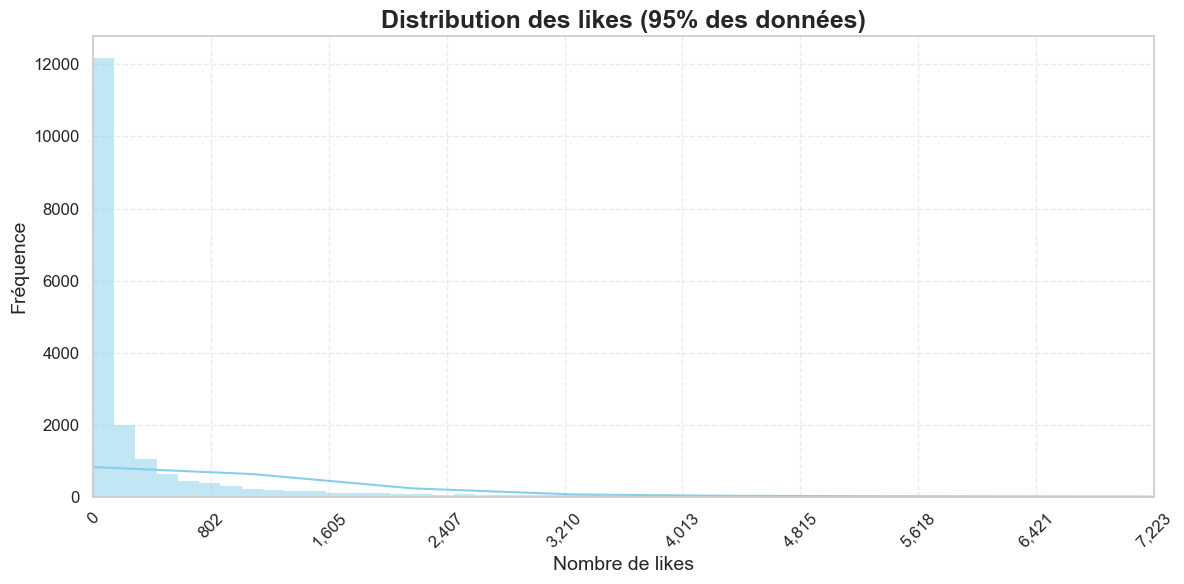

In [24]:
# Style général
sns.set(style="whitegrid")

# Création de la figure
plt.figure(figsize=(12, 6))

# Calcul des limites pour l'axe x (exclure les 5% de valeurs extrêmes)
x_max = df['like_count'].quantile(0.95)

# Histogramme avec réglage de l'échelle
ax = sns.histplot(df['like_count'].dropna(), 
                 bins=50, 
                 color='skyblue', 
                 kde=True,
                 binrange=(0, x_max))

# Titres et labels
plt.title("Distribution des likes (95% des données)", fontsize=18, fontweight='bold')
plt.xlabel("Nombre de likes", fontsize=14)
plt.ylabel("Fréquence", fontsize=14)

# Réglage précis de l'échelle des x
plt.xlim(0, x_max)
plt.xticks(np.linspace(0, x_max, 10), fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Formatage des ticks pour plus de lisibilité
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Grille personnalisée
plt.grid(True, linestyle='--', alpha=0.4, which='both')

# Ajustements finaux
plt.tight_layout()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 20565/20565 [00:07<00:00, 2795.18it/s]
C:\Users\louni\AppData\Local\Temp\ipykernel_3888\922567153.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_category', y='polarity', data=df, ax=ax[0,1], palette="Set2")


<Figure size 1400x800 with 0 Axes>

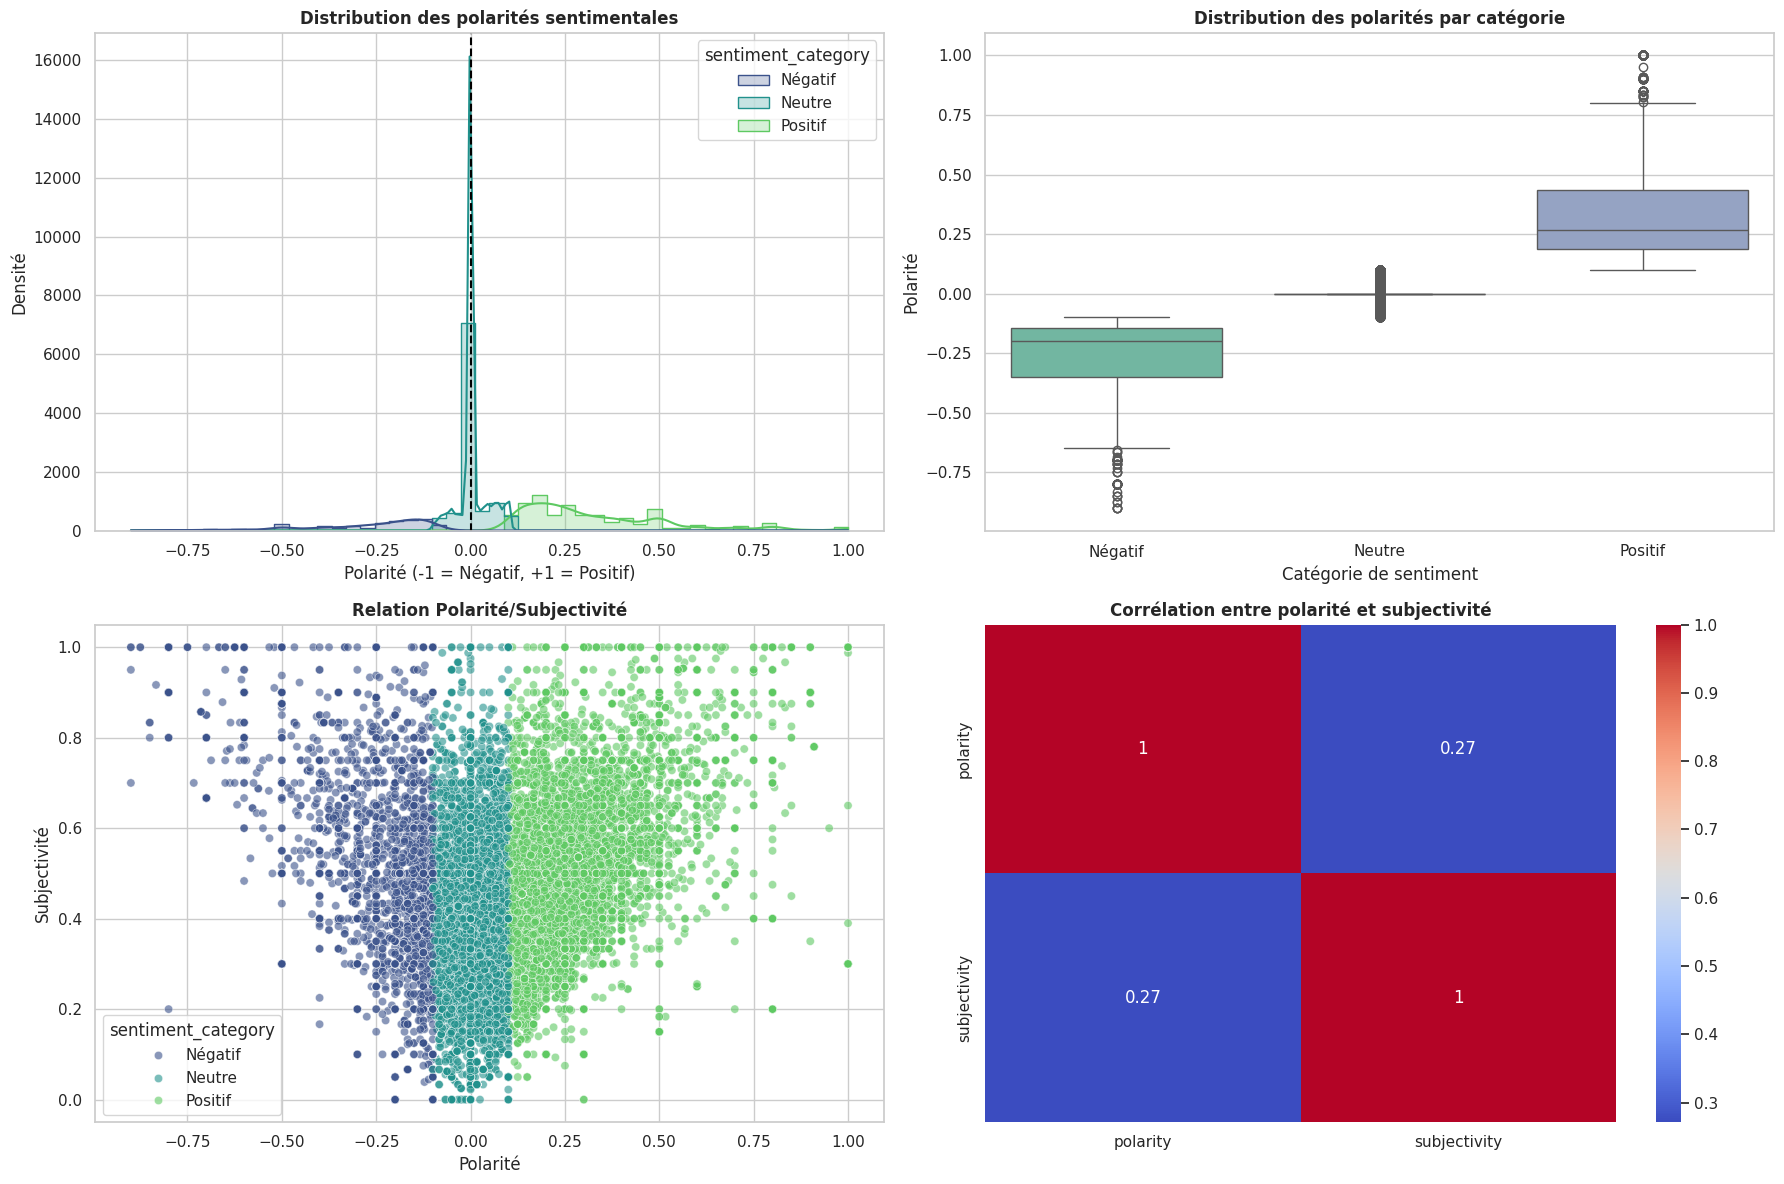


Statistiques descriptives :
                count      mean       std  min  25%       50%     75%  max
polarity      20565.0  0.093507  0.249483 -1.0  0.0  0.000000  0.2050  1.0
subjectivity  20565.0  0.362181  0.296388  0.0  0.0  0.377778  0.5625  1.0

Répartition des catégories :
sentiment_category
Neutre     0.496466
Positif    0.381683
Négatif    0.121850
Name: proportion, dtype: float64


In [25]:

tqdm.pandas()  # Activation de la barre de progression

# Configuration esthétique
sns.set(style="whitegrid", palette="coolwarm", font="DejaVu Sans")
plt.figure(figsize=(14, 8))

# Préprocessing des textes
df['clean_text'] = df['texte'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

# Calcul des sentiments avec gestion des erreurs
def get_sentiment(text):
    try:
        analysis = TextBlob(str(text))
        return analysis.sentiment
    except:
        return (0, 0)  # Valeurs par défaut pour les erreurs

# Application avec progression
sentiments = df['clean_text'].progress_apply(get_sentiment)

# Séparation des résultats
df['polarity'] = sentiments.apply(lambda x: x[0])
df['subjectivity'] = sentiments.apply(lambda x: x[1])

# Création de catégories de sentiment
df['sentiment_category'] = pd.cut(df['polarity'],
                                 bins=[-1, -0.1, 0.1, 1],
                                 labels=['Négatif', 'Neutre', 'Positif'])

# Visualisation avancée
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Distribution des polarités (CORRIGÉ)
sns.histplot(data=df, x='polarity', kde=True, bins=50, ax=ax[0,0], 
             hue='sentiment_category', palette="viridis", element='step')
ax[0,0].axvline(0, color='black', linestyle='--')
ax[0,0].set_title("Distribution des polarités sentimentales", fontweight='bold')
ax[0,0].set_xlabel("Polarité (-1 = Négatif, +1 = Positif)")
ax[0,0].set_ylabel("Densité")

# Boxplot par catégorie
sns.boxplot(x='sentiment_category', y='polarity', data=df, ax=ax[0,1], palette="Set2")
ax[0,1].set_title("Distribution des polarités par catégorie", fontweight='bold')
ax[0,1].set_xlabel("Catégorie de sentiment")
ax[0,1].set_ylabel("Polarité")

# Relation polarité/subjectivité
sns.scatterplot(x='polarity', y='subjectivity', data=df, ax=ax[1,0], hue='sentiment_category', palette="viridis", alpha=0.6)
ax[1,0].set_title("Relation Polarité/Subjectivité", fontweight='bold')
ax[1,0].set_xlabel("Polarité")
ax[1,0].set_ylabel("Subjectivité")

# Heatmap de corrélation
sns.heatmap(df[['polarity', 'subjectivity']].corr(), annot=True, cmap="coolwarm", ax=ax[1,1])
ax[1,1].set_title("Corrélation entre polarité et subjectivité", fontweight='bold')

plt.tight_layout()
plt.show()

# Statistiques résumées
print("\nStatistiques descriptives :")
print(df[['polarity', 'subjectivity']].describe().T)
print("\nRépartition des catégories :")
print(df['sentiment_category'].value_counts(normalize=True))

## Top 20 bigrammes les plus fréquents

C:\Users\louni\AppData\Local\Temp\ipykernel_3888\234254529.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=bigrams, palette='rocket')


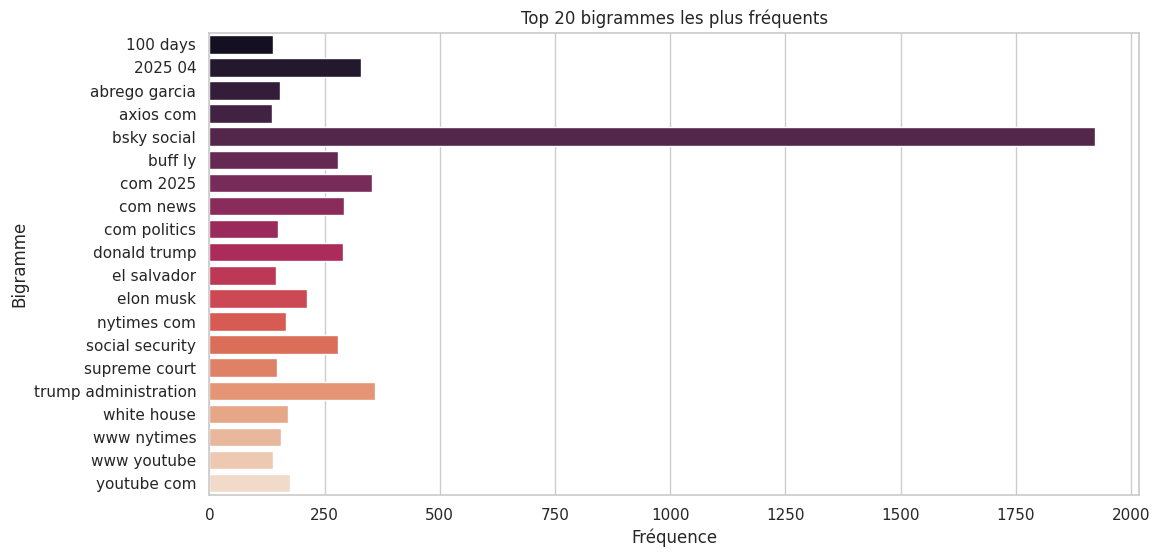

In [27]:

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['texte'].dropna().astype(str))

bigrams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1

plt.figure(figsize=(12, 6))
sns.barplot(x=counts, y=bigrams, palette='rocket')
plt.title("Top 20 bigrammes les plus fréquents")
plt.xlabel("Fréquence")
plt.ylabel("Bigramme")
plt.show()


# Le modele de détection des fake news

In [ ]:

# 1. Création d'un jeu de données synthétique équilibré (100 exemples)
real_examples = [
    "New study shows benefits of daily exercise",
    "Government announces economic stimulus package",
    "Scientists discover new species in Amazon rainforest",
    "Tech company releases new smartphone with improved camera",
    "International conference on climate change concludes",
    "Educational reforms focus on digital literacy",
    "Medical breakthrough in cancer treatment announced",
    "Renewable energy investments reach record high",
    "Local community launches recycling initiative",
    "Global tourism showing signs of recovery"
]

fake_examples = [
    "Aliens control world governments, insiders reveal",
    "Secret vaccine turns people into zombies",
    "5G towers spreading coronavirus, doctors claim",
    "Celebrity dies in mysterious circumstances",
    "Moon landing was faked, new evidence shows",
    "Secret society controls global finances",
    "Eating bananas cures COVID-19 instantly",
    "Scientists hide truth about flat Earth",
    "New device charges phone with human energy",
    "Government implants chips in COVID vaccines"
]

# Duplication pour créer un dataset plus grand
real_examples = real_examples * 10
fake_examples = fake_examples * 10

# Création des labels (0 = REAL, 1 = FAKE)
texts = real_examples + fake_examples
labels = [0] * len(real_examples) + [1] * len(fake_examples)

# 2. Modèle performant et rapide (MiniLM - 22M paramètres)
model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 3. Préparation des données
def tokenize_fn(batch):
    return tokenizer(
        batch["text"], 
        padding=True, 
        truncation=True, 
        max_length=64  # Longueur optimisée pour rapidité
    )

dataset = Dataset.from_dict({"text": texts, "label": labels})
dataset = dataset.map(tokenize_fn, batched=True, batch_size=32)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 4. Configuration d'entraînement optimisée
training_args = TrainingArguments(
    output_dir="./mini_model",
    evaluation_strategy="epoch",
    num_train_epochs=5,  # Suffisant pour convergence
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=10,
    seed=42,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
    save_strategy="no"  # Pas de sauvegarde pour gagner du temps
)

data_collator = DataCollatorWithPadding(tokenizer)

# 5. Entraînement rapide
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print("Entraînement en cours...")
trainer.train()
print("Entraînement terminé!")

# 6. Fonction de prédiction ultra-rapide
def detect_fake_news(texts: list[str]) -> list[str]:
    """Détecte si un texte est une fake news en temps réel"""
    inputs = tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=64, 
        return_tensors="pt"
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    predictions = torch.argmax(outputs.logits, dim=1)
    return ["FAKE" if p == 1 else "REAL" for p in predictions.cpu()]

# 7. Test de performance
if __name__ == "__main__":
    samples = ["NASA confirms Earth will be plunged into darkness for 6 days.",

    "The WHO declared COVID-19 is no longer a global health emergency.",

    "Apple unveils new MacBook with M3 chip.",

    "5G towers spread coronavirus."
    ]
    
    results = detect_fake_news(samples)
    for text, label in zip(samples, results):
        print(f"[{label}] {text}")

## --> Visualisations sur power BI des résultats

# Analyse des émotions 

In [7]:
# Traduction FR → EN
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")

# Détection des émotions en anglais
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=1)


C:\Users\louni\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\louni\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [8]:
def detect_emotion_translated(text, threshold=0.5):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral", 0.0, ""
    
    # Traduction
    translated = translator(text)[0]['translation_text']
    print(f"Traduction : {translated}")
    
    # Classification émotionnelle
    results = emotion_classifier(translated)
    print(f"Résultats emotion_classifier : {results}")
    
    # Descendre dans la liste imbriquée
    label = results[0][0]['label']
    score = results[0][0]['score']
    
    print(f"Label détecté : {label}, Score : {score}")
    
    if score < threshold:
        return "neutral", round(score, 3), translated
    return label, round(score, 3), translated


In [9]:
# Test
test_phrase = "je suis très malade"
emotion, confidence, translated_text = detect_emotion_translated(test_phrase)

print(f"Texte original : {test_phrase}")
print(f"Traduction : {translated_text}")
print(f"Émotion détectée : {emotion}")
print(f"Confiance : {confidence}")


Traduction : I'm very sick.
Résultats emotion_classifier : [[{'label': 'sadness', 'score': 0.5362010598182678}]]
Label détecté : sadness, Score : 0.5362010598182678
Texte original : je suis très malade
Traduction : I'm very sick.
Émotion détectée : sadness
Confiance : 0.536


In [10]:
# Charger le fichier CSV
df = pd.read_csv("posts_recuperes_2.csv")

# Garder les 150 premiers tweets non vides dans la colonne 'text'
df_subset = df[['text']].dropna().head(150).copy()

# Fonction d’analyse émotionnelle (assure-toi que translator et emotion_classifier sont bien définis)
def detect_emotion_translated(text, threshold=0.5):
    if not isinstance(text, str) or text.strip() == "":
        return "neutral", 0.0, ""
    
    translated = translator(text)[0]['translation_text']
    results = emotion_classifier(translated)
    
    label = results[0][0]['label']
    score = results[0][0]['score']
    
    if score < threshold:
        return "neutral", round(score, 3), translated
    return label, round(score, 3), translated

# Fonction simplifiée pour ne garder que l’émotion et la confiance
def detect_emotion_only(text):
    emotion, confidence, _ = detect_emotion_translated(text)
    return f"{emotion} | {confidence}"

# Appliquer la détection d’émotion
df_subset['emotion'] = df_subset['text'].apply(detect_emotion_only)

# Sauvegarder dans un nouveau CSV
df_subset.to_csv("tweets_150_emotions.csv", index=False)

print("Traitement terminé. Résultat enregistré dans 'tweets_150_emotions.csv'.")


Traitement terminé. Résultat enregistré dans 'tweets_150_emotions.csv'.


## --->  Visualisations sur power BI des résultats